# Inroduction

This notebook demonstrates a toy scenario of a network with users, systems and resources, and how structural information can be identified using graph explainers in order to make strategic red-team and blue-team decisions.

The network graph is built programmatically and randomly based on various parameters. The graph is homogeneous; metadata stores the node type (user, system, resource).

The graph learning in this notebook is transductive, meaning it's learning about a single given graph. That was chosen for simplicity. However, the code could be extended to be inductive by training on many randomly generated graphs. GraphSAGE is a framework appropriate for inductive learning on graphs, and its model components are used here.

Importantly, in the generated graphs there is a notion of compromised user(s) and high-value resources. From a red-teaming perspective, a compromised user might be a known target, and a high-value resource might be identified as high-value after initial reconnaissance.

For the purposes of this toy example, the compromised user label provides a classification problem for transductive learning. This is useful because it provides a way to learn node embedding vectors; however, node vectors could be learned in an unsupervised context as well; for example, using Deep Graph Infomax (DGI) which is implemented in _pytorch_geometric_, as is GraphSAGE.

After doing transductive learning on the generated graph using a 2-layer GNN, we then use the GNNExplainer, also from _pytorch_geomtric_, to identify nodes that: (1) contribute most to the target node’s prediction, (2) are bottlenecks in information flow, (3) determine classification outcomes (e.g., malicious vs. benign).

In simple terms, GNNExplainer works by turning edges and features off, and the ones it can’t remove without changing the model’s answer are the important parts of the graph.

Overall steps taken are:
1) build a random graph
2) learn to classify user nodes in the graph by risk
3) run the graph explainer to identify salient structure in the graph
4) extract the explainer's edge info about a high-risk user and high-value resource(s)
5) call OpenAI API to translate the explainer details into red and blue team recommendations
6) visualize the graph

In [76]:
import torch
import torch.nn.functional as F
from torch_geometric.explain  import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode

## Build the toy "access" graph

In [77]:
from random_access_graph import generate_access_graph

# build a random graph
data, meta = generate_access_graph(
    n_users=8, n_systems=6, n_resources=10,
    p_login=0.3, p_lateral=0.04, p_sys_access=0.4,
    p_cross_user_cluster=0.15, n_user_clusters=3,
    high_value_ratio=0.15,
    seed=99
)

## Create a tiny GCN or GraphSAGE model

In [78]:
from gnn_factory import build_gnn

MODEL_NAME = "sage"          # <── swap "gcn"  /  "sage"
model = build_gnn(MODEL_NAME,
                  in_dim=3,
                  hidden=32,
                  n_classes=2)
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
for _ in range(200):
    opt.zero_grad()
    out  = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward(); opt.step()
model.eval()

SAGENodeClassifier(
  (conv1): SAGEConv(3, 32, aggr=mean)
  (conv2): SAGEConv(32, 32, aggr=mean)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)

In [79]:
# Single-graph TRAIN accuracy (1.0 here because the only malicious user is in train_mask).
# The score is not a useful metric; we train purely to obtain embeddings
# that GNNExplainer will analyse.  Unsupervised objectives (e.g. DGI) could serve the
# same purpose if no labels were available.
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    pred   = logits.argmax(dim=1)
    acc    = (pred[data.train_mask] == data.y[data.train_mask]).float().mean()
print(f"Train accuracy: {acc:.3f}")

Train accuracy: 1.000


## Run GNNExplainer

In [80]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=500, lr=0.005),        # more epochs → clearer masks
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=ModelConfig(
        mode=ModelMode.multiclass_classification,
        task_level='node',
        return_type='raw',                     # logits
    ),
)

## Calculate risk scores and braodcast scores

In [81]:
from helper_tabular import get_node_types
from rank_user_compromise import rank_users, broadcast_scores

top_users = rank_users(data, model, k=3, node_types=get_node_types(meta))
print("=== highest-risk users ===")
print(top_users)

bc = broadcast_scores(data, explainer, top_users["node_id"])
print("\n=== broadcast score ===")
print(bc)

=== highest-risk users ===
   node_id  type  p_compromised
0        7  user       0.850949
1        4  user       0.004610
2        5  user       0.000280

=== broadcast score ===
   node_id  broadcast_score
0        7         5.582482
1        5         1.402578
2        4         0.192996


In [82]:
# for now, only keep the explaination for the user node with highest risk score
node_ids = top_users["node_id"].tolist()
for node_id in top_users["node_id"]:
    explanation = explainer(data.x, data.edge_index, index=node_id)
    break

# Review the explanation and related data 

In [83]:
# look at the importance of the features for the high risk user node
feat_names = meta["data_feature_names"]
row = explanation.node_mask[node_id]           # (3,) tensor
for w, n in sorted(zip(row.tolist(), feat_names), reverse=True):
    print(f"{n:<15} {w:6.3f}")

anomaly_score    0.879
login_freq       0.864
is_admin         0.000


In [84]:
# Look at influential edges related to the high risk user node (not necessarily connected to that node)

print(f"\nTop-5 influential edges for node {node_id}:")
edge_scores = explanation.edge_mask
edge_idx_T  = data.edge_index.t()
top = torch.topk(edge_scores, 5)
for s, idx in zip(top.values, top.indices):
    u, v = edge_idx_T[idx].tolist()
    print(f"{u:>2} → {v:<2}  score={s:.3f}")


Top-5 influential edges for node 7:
 7 → 8   score=0.952
 5 → 11  score=0.951
 0 → 12  score=0.950
 0 → 11  score=0.947
 4 → 10  score=0.947


In [85]:
from helper_tabular import TabularData, NodeCategories

# Get tabular data for easier, further inspection
node_categories = NodeCategories(meta)
tabular_data = TabularData(data, meta, explanation, node_id)
node_info = tabular_data.get_per_node_info()
edge_info = tabular_data.get_per_edge_info()

In [86]:
print(node_info)

    node_id      type  is_admin  login_freq   anomaly  label
0         0      user       0.0    0.148144  0.258237      0
1         1      user       0.0    0.971648  0.146446      0
2         2      user       0.0    0.950667  0.239417      0
3         3      user       0.0    0.979773  0.060331      0
4         4      user       0.0    0.360426  0.057408      0
5         5      user       0.0    0.924026  0.269381      0
6         6      user       1.0    0.097761  0.286231      0
7         7      user       0.0    0.863974  0.879219      1
8         8    system       0.0    0.000000  0.000000      0
9         9    system       0.0    0.000000  0.000000      0
10       10    system       0.0    0.000000  0.000000      0
11       11    system       0.0    0.000000  0.000000      0
12       12    system       0.0    0.000000  0.000000      0
13       13    system       0.0    0.000000  0.000000      0
14       14  resource       0.0    0.000000  0.000000      0
15       15  resource   

In [87]:
print(edge_info)

    src  dst  importance     kind
0     0   10    0.042128    login
1     0   11    0.947282    login
2     0   12    0.949784    login
3     1   10    0.930158    login
4     1   12    0.935163    login
..  ...  ...         ...      ...
89   21   13    0.000000  sys→res
90   22   13    0.000000  sys→res
91   23   13    0.000000  sys→res
92    1    0    0.000000  lateral
93   12    9    0.000000    other

[94 rows x 4 columns]


## Define Targets

In [88]:
# We want to be able to exploit the explainer's info about the graph.
# Above we looked at high risk user info. Now let's look at high value resources.
# Then we'll get actionable insights for both.

# 1) decide resource target(s)
targets = meta.get('high_value', []) or meta['resources']
targets

[17]

In [89]:
from helper_tabular import explain_resource_paths

# 2) for each high-value resource, get the top K conduit edges
all_hv_reports = {}
for rid in targets:
    hv_df, hv_nodes = explain_resource_paths(data, meta, explainer, rid, top_k=10)
    all_hv_reports[rid] = hv_df        # store for dashboards / bullets
    print(f"\nTop paths to resource {rid}")
    print(hv_df[['src','dst','importance','kind']])

# also, get the top K user edges
topk_edges = tabular_data.get_topk_edges()


Top paths to resource 17
   src  dst  importance     kind
0    5    9    0.954595    login
1    3    9    0.953948    login
2    9   17    0.048100  sys→res
3    0   12    0.048096    login
4    7   12    0.047847    login
5   12   17    0.047654  sys→res
6    1   12    0.047209    login
7    8    6    0.000000    login
8   12    7    0.000000    login
9   16    8    0.000000  sys→res


## Create an LLM explanation summary from top edges

In [90]:
from helper_llm_explain import explain_edges_with_llm, build_edge_sentence_fn
import json

to_sentence = build_edge_sentence_fn(node_categories.users, node_categories.systems, node_categories.resources)

# make API call to LMM to get resource and user edge actions
resource_bullets = "\n".join("• "+to_sentence(r) for _, r in hv_df.iterrows())
user_bullets = "\n".join("• "+to_sentence(r) for _, r in topk_edges.iterrows())
report_resource = explain_edges_with_llm(resource_bullets)
report_user = explain_edges_with_llm(user_bullets)

In [91]:
print("=== Resource Report ===")
print(resource_bullets)
print("-"*100)
print(json.dumps(report_resource, indent=2))

=== Resource Report ===
• User 5 logs into system 9 (w=0.95)
• User 3 logs into system 9 (w=0.95)
• System 9 accesses resource 17 (w=0.05)
• User 0 logs into system 12 (w=0.05)
• User 7 logs into system 12 (w=0.05)
• System 12 accesses resource 17 (w=0.05)
• User 1 logs into system 12 (w=0.05)
• User 6 logs into system 8 (w=0.00)
• User 7 logs into system 12 (w=0.00)
• System 8 accesses resource 16 (w=0.00)
----------------------------------------------------------------------------------------------------
{
  "red_team": [
    {
      "issue": "User 3 and User 5 both access System 9",
      "why": "Both User 3 and User 5 have logged into System 9, making it a target for credential theft or lateral movement.",
      "steps": "1. Capture credentials from User 3 on System 9. 2. Use stolen credentials to access System 9 as User 5. 3. Exfiltrate data from System 9."
    }
  ],
  "blue_team": [
    {
      "focus": "System 9 and User 3, User 5",
      "why": "Monitoring access to System 9 c

In [92]:
print("=== User Report ===")
print(user_bullets)
print("-"*100)
print(json.dumps(report_user, indent=2))

=== User Report ===
• User 7 logs into system 8 (w=0.95)
• User 5 logs into system 11 (w=0.95)
• User 0 logs into system 12 (w=0.95)
• User 0 logs into system 11 (w=0.95)
• User 4 logs into system 10 (w=0.95)
• User 4 logs into system 8 (w=0.95)
• User 7 logs into system 10 (w=0.95)
• User 3 logs into system 11 (w=0.94)
• User 7 logs into system 12 (w=0.94)
• User 7 logs into system 11 (w=0.94)
----------------------------------------------------------------------------------------------------
{
  "red_team": [
    {
      "issue": "User 7 accesses system 11 and system 12",
      "why": "User 7 has multiple high-confidence logins, indicating potential for lateral movement between systems 11 and 12.",
      "steps": "1. Exploit User 7's session on system 11. 2. Use credentials to access system 12. 3. Gather sensitive data from both systems."
    },
    {
      "issue": "User 0 logs into system 11 and system 12",
      "why": "User 0 has access to two critical systems, which can be lever

## Visualise the graph

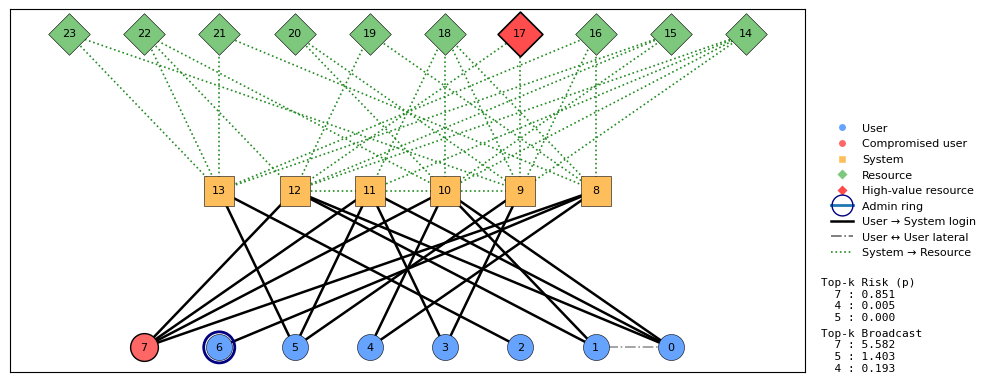

In [93]:
from visualize_graph import visualize_graph
visualize_graph(data, meta, top_users, bc)